In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from matplotlib.lines import Line2D
import ast
from statannot import add_stat_annotation

In [77]:
exp_measures = pd.read_csv("data/measures.csv")

condition_map = utils.get_nudge_condition_map()
conditions = condition_map.values()
exp_measures["a_values"] = exp_measures.a_values.apply(ast.literal_eval).apply(tuple)
exp_measures["condition"] = pd.Categorical(exp_measures["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)

In [101]:
def plot_var_by_condition(exp_measures, model_measures, var, model_label, include_model=True, include_legend=False, subfigure_label=""):
    tta_conditions = [4.5, 5.5]
    d_0 = 80
    markers=["o", "s"]
    colors = ["C0", "C1"]

    fig, ax = plt.subplots(1, 1, figsize=(3,3), sharex=True, sharey=True)
    # ax = axes[0]
    # for tta, ax in zip([4.5, 5.5], axes):
    for tta, color, marker in zip(tta_conditions, colors, markers):
        exp_measures_by_condition = exp_measures[(exp_measures.tta_0 == tta)]

        if include_model:
            model_measures_by_condition = model_measures[(model_measures.tta_0==tta) & (model_measures.d_0==d_0)].sort_values("condition")

        if (var == "is_go_decision") | (var == "is_negative_rating"):
            psf_ci = utils.get_psf_ci(exp_measures_by_condition, var=var)
            ax.plot(psf_ci.condition, psf_ci.p, ls="", marker=marker, ms=9, color=color, zorder=10)
            ax.vlines(x=psf_ci.condition, ymin=psf_ci.ci_l, ymax=psf_ci.ci_r, color=color, zorder=10)

            if include_model:
                ax.plot(model_measures_by_condition.condition, model_measures_by_condition.is_gap_accepted, color=color, label=tta)
            ax.set_ylim((0, 1) if (var == "is_go_decision") else (0, 0.35))
        else:
            exp_measures_by_condition = (exp_measures_by_condition[(exp_measures_by_condition.is_go_decision)]
                                         if var == "RT_go"
                                         else exp_measures_by_condition[~(exp_measures_by_condition.is_go_decision)])

            measures_mean_sem = utils.get_mean_sem(exp_measures_by_condition, var="RT",
                                                   groupby_var="condition", n_cutoff=10).reindex(conditions)
            ax.errorbar(measures_mean_sem.index, measures_mean_sem["mean"], yerr=measures_mean_sem["sem"], ls="", marker=marker, ms=9, color=color)
            if include_model:
                ax.plot(model_measures_by_condition.condition, model_measures_by_condition[var], color=color, label=tta)

            # ax.set_ylim((0.3, 2.3))

        # ax.set_xlim((model_measures_by_condition.d_condition.min(), model_measures_by_condition.d_condition.max()))
        # ax.set_xlabel("Distance to vehicle, m", fontsize=12)
        # ax.set_title("TTA to vehicle=%is" % (tta), fontsize=12)

    # axes[0].set_ylabel(var, fontsize=16)
    if var=="is_go_decision":
        ylabel = "p(go)"

        if include_model == False:
            x1, x2 = 1, 2
            y, h, color = psf_ci.p.max() - 0.15, 0.02, "grey"
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=color)
            ax.text((x1+x2)*.5, y+h, "n.s.", ha='center', va='bottom', color=color)

            x1, x2 = 2, 3
            y, h, color = psf_ci.p.max() + 0.05, 0.02, "grey"
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=color)
            ax.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=color)
    elif var=="is_negative_rating":
        ylabel = "p(negative rating)"
    elif var=="RT_go":
        ylabel = "go RT"
    elif var=="RT_stay":
        ylabel = "stay RT"

    ax.set_ylabel(ylabel, fontsize=12)

    fig.text(0.0, 1.0, subfigure_label, fontsize=12)

    sns.despine(offset=5, trim=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    plt.tight_layout()

    if include_legend:
        legend_elements = ([Line2D([0], [0], color=color, marker=marker, ms=9, lw=0,
                                   label="Data, TTA=%.1fs" % (tta_condition))
                            for tta_condition, color, marker in zip(tta_conditions, colors, markers)]
                           + ([Line2D([0], [0], color="grey", label="Model")] if include_model else []))

        if include_model:
            fig.legend(handles=legend_elements, loc="lower left", bbox_to_anchor=(1.0, 0.32), fontsize=14, frameon=False)
        else:
            fig.legend(handles=legend_elements, frameon=False)
    plt.savefig("figures/%s_%s_model_%r.png" % (var, model_label, include_model), bbox_inches="tight")

# Experimental results

### RT distributions

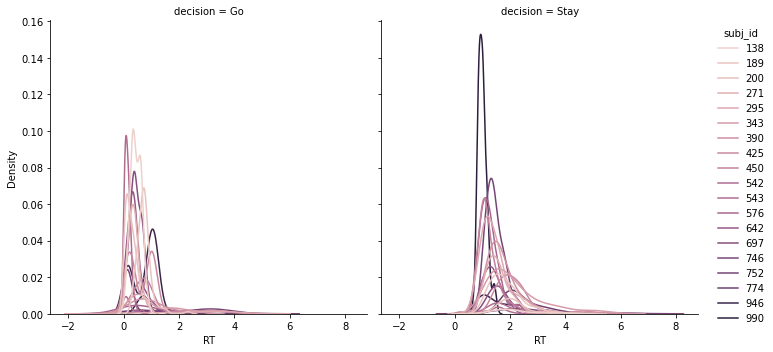

In [4]:
sns.displot(data=exp_measures, x="RT", hue="subj_id", col="decision", kind="kde", clip=(0, 6))

### Mean differences

In [14]:
exp_measures[np.isnan(exp_measures.RT) & ~(exp_measures.is_go_decision)].groupby("subj_id").size()

subj_id
138      7
189      6
200      8
295     10
343     11
390      7
425      5
450      1
542      2
543      1
642      4
697      4
746      4
752      1
774    130
946      7
990      2
dtype: int64

All data

In [5]:
exp_measures.groupby(["tta_0", "condition"]).is_go_decision.mean()

tta_0  condition         
4.5    Long acceleration     0.263158
       Acceleration nudge    0.355263
       Constant speed        0.389474
       Deceleration nudge    0.431579
       Long deceleration     0.471053
5.5    Long acceleration     0.484211
       Acceleration nudge    0.557895
       Constant speed        0.552632
       Deceleration nudge    0.639474
       Long deceleration     0.842105
Name: is_go_decision, dtype: float64

15 subjects

In [150]:
exp_measures.groupby(["tta_0", "condition"]).is_go_decision.mean()

tta_0  condition         
4.5    Long acceleration     0.257143
       Acceleration nudge    0.342857
       Constant speed        0.392857
       Deceleration nudge    0.450000
       Long deceleration     0.500000
5.5    Long acceleration     0.517857
       Acceleration nudge    0.596429
       Constant speed        0.589286
       Deceleration nudge    0.714286
       Long deceleration     0.925000
Name: is_go_decision, dtype: float64

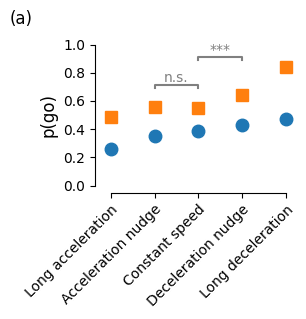

In [99]:
plot_var_by_condition(exp_measures, None, var="is_go_decision", model_label=None,
                      include_model=False, include_legend=False, subfigure_label="(a)")

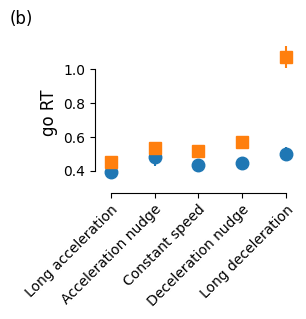

In [100]:
plot_var_by_condition(exp_measures, None, var="RT_go", model_label=None,
                      include_model=False, include_legend=False, subfigure_label="(b)")

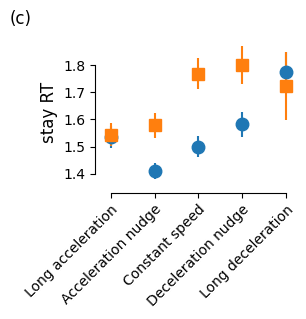

In [98]:
plot_var_by_condition(exp_measures, None, var="RT_stay", model_label=None,
                      include_model=False, include_legend=False, subfigure_label="(c)")

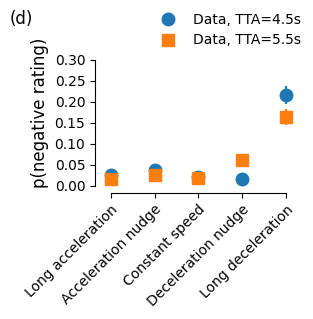

In [97]:
plot_var_by_condition(exp_measures, None, var="is_negative_rating", model_label=None,
                      include_model=False, include_legend=True, subfigure_label="(d)")

# Modeling (excluding NaN RTs) - Model 3 - cross-validation on Nudge conditions

In [102]:
model_label_cv="model_acceleration_dependent_cross_validation"
model_measures_cv = pd.read_csv("modeling/fit_results_excluded_nan_rt/%s/subj_all_sim_measures.csv" % model_label_cv)
model_measures_cv["a_values"] = model_measures_cv.a_values.apply(ast.literal_eval).apply(tuple)
model_measures_cv["condition"] = pd.Categorical(model_measures_cv["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)

### Decision

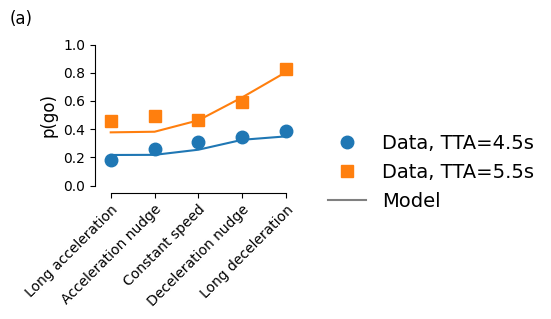

In [104]:
plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures_cv, var="is_go_decision", model_label=model_label_cv, include_model=True, include_legend=True, subfigure_label="(a)")

### RT go

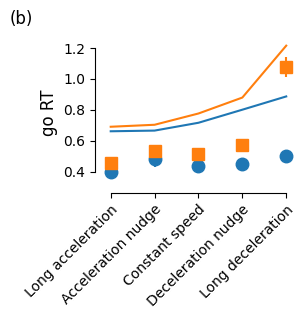

In [106]:
plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures_cv, var="RT_go", model_label=model_label_cv, include_model=True, subfigure_label="(b)")

### RT stay

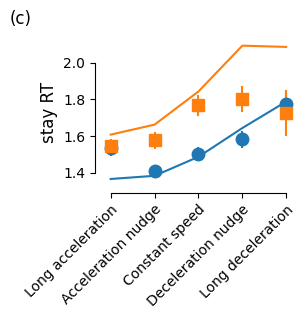

In [107]:
plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures_cv, var="RT_stay", model_label=model_label_cv, include_model=True, subfigure_label="(c)")

# Model predictions

In [108]:
model_label="model_acceleration_dependent_cross_validation"
model_measures = pd.read_csv("modeling/fit_results_excluded_nan_rt/%s/prediction_subj_all_sim_measures.csv" % model_label)
model_measures["a_values"] = model_measures.a_values.apply(ast.literal_eval).apply(tuple)

In [109]:
model_measures["a_magnitude"] = model_measures.a_values.apply(lambda x: x[2])

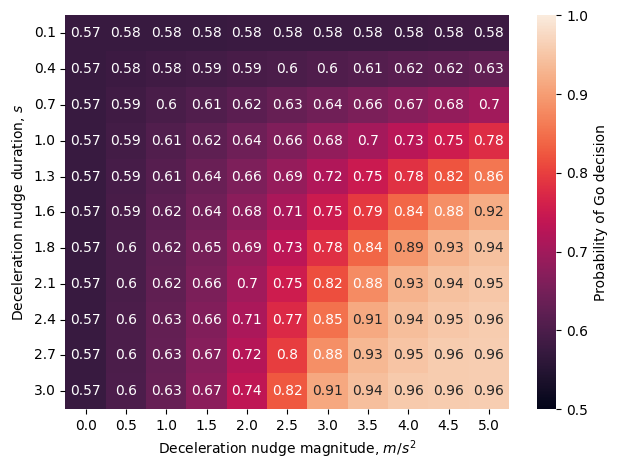

In [35]:
p_go = model_measures.pivot(index="a_duration", columns="a_magnitude", values="is_gap_accepted")
ax = sns.heatmap(p_go, vmin=0.5, vmax=1, annot=True, cbar_kws={"label": "Probability of Go decision"})
ax.set_xlabel("Deceleration nudge magnitude, $m/s^2$")
ax.set_ylabel("Deceleration nudge duration, $s$")
ax.set_yticklabels(['{:,.1f}'.format(x) for x in p_go.index.get_level_values(0)]);
plt.tight_layout()
plt.savefig("figures/predictions.png", bbox_inches="tight")

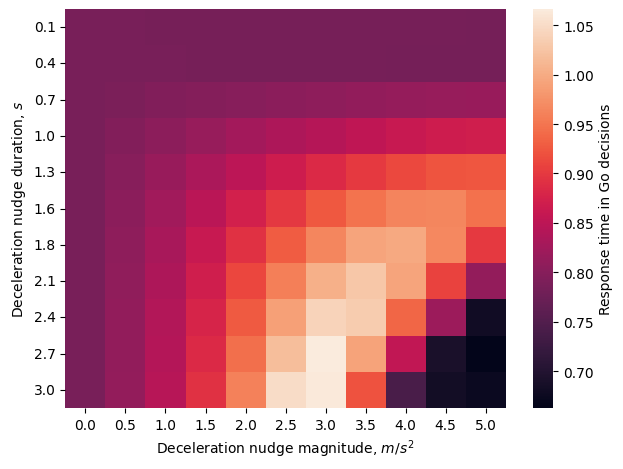

In [56]:
rt_go = model_measures.pivot(index="a_duration", columns="a_magnitude", values="RT_go")
ax = sns.heatmap(rt_go, cbar_kws={"label": "Response time in Go decisions"})
ax.set_xlabel("Deceleration nudge magnitude, $m/s^2$")
ax.set_ylabel("Deceleration nudge duration, $s$")
ax.set_yticklabels(['{:,.1f}'.format(x) for x in p_go.index.get_level_values(0)]);
plt.tight_layout()
plt.savefig("figures/predictions_RT_go.png", bbox_inches="tight")

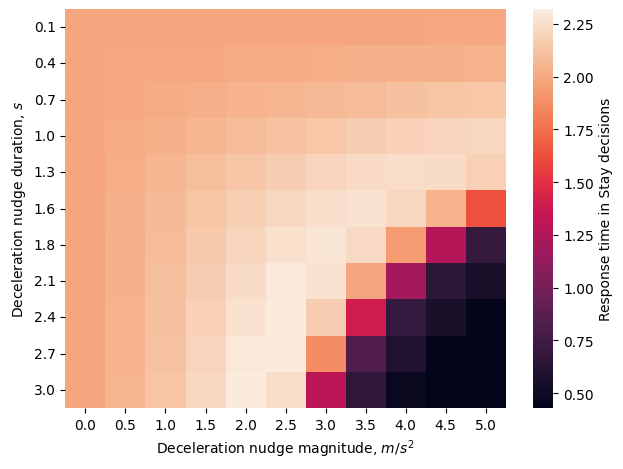

In [58]:
rt_stay = model_measures.pivot(index="a_duration", columns="a_magnitude", values="RT_stay")
ax = sns.heatmap(rt_stay, cbar_kws={"label": "Response time in Stay decisions"})
ax.set_xlabel("Deceleration nudge magnitude, $m/s^2$")
ax.set_ylabel("Deceleration nudge duration, $s$")
ax.set_yticklabels(['{:,.1f}'.format(x) for x in p_go.index.get_level_values(0)]);
plt.tight_layout()
plt.savefig("figures/predictions_RT_stay.png", bbox_inches="tight")